# StreamSim: generate stream mocks

Create stellar-stream mock catalogs from a config and complete existing tables with missing columns.

You’ll learn:
- Model pieces: density, track, distance modulus, isochrone
- Build/load a config and sample a mock
- Complete a partial catalog (e.g., add magnitudes)

In [1]:
import sys
import os
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Set the base directory 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(base_dir) # to be able to find ./config/myfile.yaml

# Add base directory to the Python path for imports
sys.path.append(base_dir)


In [2]:
# Import necessary modules form stream_sim
%load_ext autoreload
%autoreload 2
from stream_sim.utils import parse_config
from stream_sim.model import StreamModel

# 1) Build a stream configuration
Use a dict or a YAML file; components:
- density: samples phi1 along the stream
- track: gives phi2 given phi1 (center + spread, with Gaussian or Uniform sampler)
- distance_modulus: DM(phi1) for apparent magnitudes
- isochrone: CMD sampling (required for magnitudes)

Notes:
- Minimum for magnitudes: both `distance_modulus` and `isochrone`
- Velocity model is a placeholder (NaN outputs)
- Samplers/functions are passed via `type` (e.g., 'Uniform', 'CubicSplineInterpolation')

In [3]:
# Build a config dictionary directly

config = { 
          'nstars': 5000.0,  # number of stars to sample.

          # Density model
          'density': {'type': 'Uniform', 'xmin': -9.0, 'xmax': 9.0}, 

          # Track model
           'track': {'center': {'type': 'Constant', 'value': 0.0}, # center line of the stream in degrees
                     'spread': {'type': 'Constant', 'value': 0.2}, # spread of the stream in degrees
                     'sampler': 'Gaussian'}, # how to sample across the stream

            # Isochrone model
            'isochrone': {'name': 'Bressan2012', # isochrone set name
                          'survey': 'lsst', # survey for filter set
                          'age': 12.0, # Age in Gyr of the population
                          'z': 0.0006, # Metallicity of the population
                          'band_1': 'g', # first band for color-magnitude
                          'band_2': 'r', # second band for color-magnitude
                          'band_1_detection': True}, 

            # Distance modulus model. Here an example of a constant distance modulus
            'distance_modulus': {'center':  {'type': 'Constant', 'value': 16.5}, 
                                 'spread': {'type': 'Constant', 'value': 0.0}, 
                                }
}

# or load from a config file
#config_path = os.path.join(base_dir, 'config', 'toy1_config.yaml')
#config = parse_config(config_path)['stream']

print(config)

{'nstars': 5000.0, 'density': {'type': 'Uniform', 'xmin': -9.0, 'xmax': 9.0}, 'track': {'center': {'type': 'Constant', 'value': 0.0}, 'spread': {'type': 'Constant', 'value': 0.2}, 'sampler': 'Gaussian'}, 'isochrone': {'name': 'Bressan2012', 'survey': 'lsst', 'age': 12.0, 'z': 0.0006, 'band_1': 'g', 'band_2': 'r', 'band_1_detection': True}, 'distance_modulus': {'center': {'type': 'Constant', 'value': 16.5}, 'spread': {'type': 'Constant', 'value': 0.0}}}


In [4]:
# Create stream model and generate stars
stream_model = StreamModel(config)
stream_df = stream_model.sample(int(config['nstars']))

# The dataframe contains: phi1, phi2, distance, magnitudes, etc.
print(f"✓ Generated {len(stream_df)} stars")
print("\nFirst 5 stars:")
print(stream_df.head())

✓ Generated 5000 stars

First 5 stars:
       phi1      phi2  dist   mu1   mu2    rv      mag_g      mag_r
0  0.315409  0.188177  16.5  None  None  None  28.836643  27.512986
1 -6.697976  0.064819  16.5  None  None  None  27.882248  26.717813
2 -4.471355 -0.133839  16.5  None  None  None  25.345504  24.510736
3  6.859378  0.360799  16.5  None  None  None  28.839912  27.515589
4  4.757834  0.340916  16.5  None  None  None  30.116327  28.567245


Text(0.5, 1.0, 'Color-Magnitude Diagram')

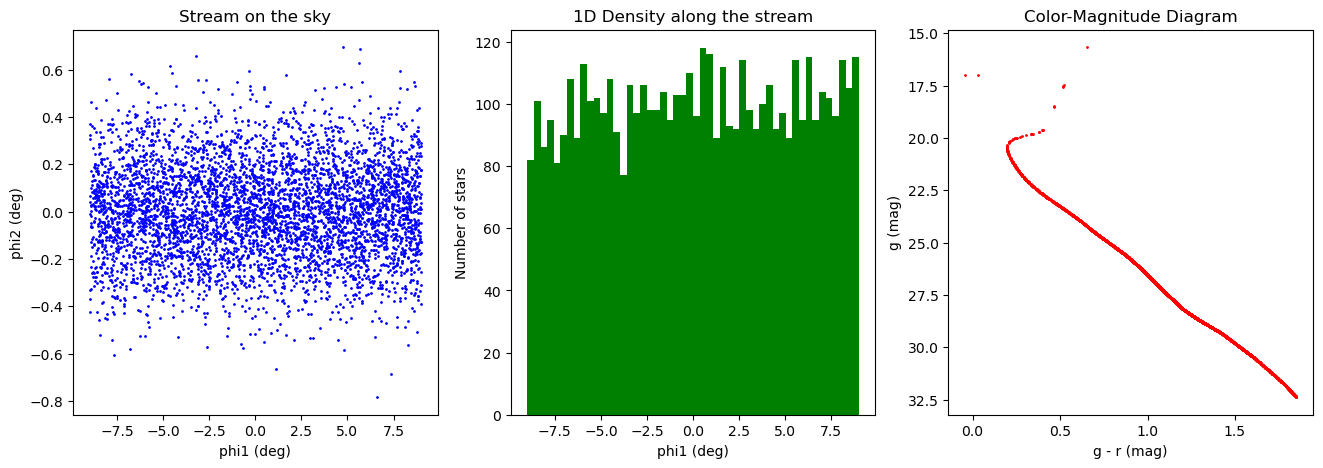

In [5]:
# Quick look: sky track, 1D density, CMD
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# Stream on the sky
ax[0].scatter(stream_df['phi1'], stream_df['phi2'], s=1, color='blue')
ax[0].set_xlabel('phi1 (deg)')
ax[0].set_ylabel('phi2 (deg)')
ax[0].set_title('Stream on the sky')

# 1D density
ax[1].hist(stream_df['phi1'], bins=50, color='green')
ax[1].set_xlabel('phi1 (deg)')
ax[1].set_ylabel('Number of stars')
ax[1].set_title('1D Density along the stream')

# Color-magnitude diagram
ax[2].scatter(stream_df['mag_g'] - stream_df['mag_r'], stream_df['mag_g'], s=1, color='red')
ax[2].set_xlabel('g - r (mag)')
ax[2].set_ylabel('g (mag)')
ax[2].invert_yaxis()
ax[2].set_title('Color-Magnitude Diagram')

# 2) Spline-based configuration 
You can describe a richer stream shape with cubic splines, especially for the following quantities:
- linear density = = sqrt(2π) × peak_intensity × spread
- distance modulus
- track and width

In this example we use the data from `data/patrick_2022_splines.csv` and select `stream == 'phoenix'`.

In [ ]:
# Nodes and values for the spline-based stream model (from Patrick et al. 2022, for Phoenix stream)
# One may read these from a CSV file instead of hardcoding them, cf to config/atlas_spline_config.yaml
intensity_nodes = np.array([-13., -9.75, -8.125, -4.1640625, -3.25, -1.625, 1.625, 6.5, 8.125, 13.])
intensity_node_values = np.array([2.35582279e-07, 2.65789495e-02, 5.94765580e-02, 7.20106921e-02, 9.96003626e-02, 4.68656926e-02, 7.42352023e-02, 4.75688845e-06, 1.73046024e-02, 4.08879937e-08])
spread_nodes =  np.array([-13. , 13.])
spread_node_values = np.array([0.0992389,  0.17083177])
center_nodes = np.array([-13., 4.33333333, 13.])
center_node_values = np.array([0.19313599, 0.07139282, 0.60245054])
distance_nodes = np.array([-13., 13.])
distance_node_values = np.array([16.38285347, 16.1136374])


config_spline = {
    # Density model using cubic splines from CSV
    'density': {
        'type': 'lineardensitycubicsplineinterpolation',
        'intensity_nodes': intensity_nodes,
        'intensity_node_values': intensity_node_values,
        'spread_nodes': spread_nodes,
        'spread_node_values': spread_node_values,
    },

    # Track model: center and spread as cubic splines
    'track': {
        'center': {'type': 'CubicSplineInterpolation', 'nodes': center_nodes, 'node_values': center_node_values},
        'spread': {'type': 'CubicSplineInterpolation', 'nodes': spread_nodes, 'node_values': spread_node_values},
    },

    # Isochrone model
    'isochrone': {
        'name': 'Bressan2012',
        'survey': 'lsst',
        'age': 13.0,
        'z': 0.0004,
        'band_1': 'g',
        'band_2': 'r',
        'band_1_detection': True
    },

    # Distance modulus model as a cubic spline (flat default)
    'distance_modulus': {
        'center': {'type': 'CubicSplineInterpolation', 'nodes': distance_nodes, 'node_values': distance_node_values},
        'spread': {'type': 'Constant', 'value': 0.0},
    },
}


In [7]:
# Optional: sample using the spline-based config
stream_model_spline = StreamModel(config_spline)
stream_df_spline = stream_model_spline.sample(4000)

print(f"✓ Generated {len(stream_df_spline)} stars with spline density")
stream_df_spline.head()

✓ Generated 4000 stars with spline density


,phi1,phi2,dist,mu1,mu2,rv,mag_g,mag_r
0,1.479805,0.077215,16.232923,None,None,None,27.658314,26.488429
1,-8.383914,0.322526,16.335056,None,None,None,27.140079,26.047978
2,-2.587936,0.081982,16.275042,None,None,None,30.140541,28.551808
3,-9.362304,0.053499,16.345187,None,None,None,26.533106,25.516250
4,-2.733797,0.049730,16.276552,None,None,None,25.372983,24.497378


Text(0.5, 1.0, 'Color-Magnitude Diagram')

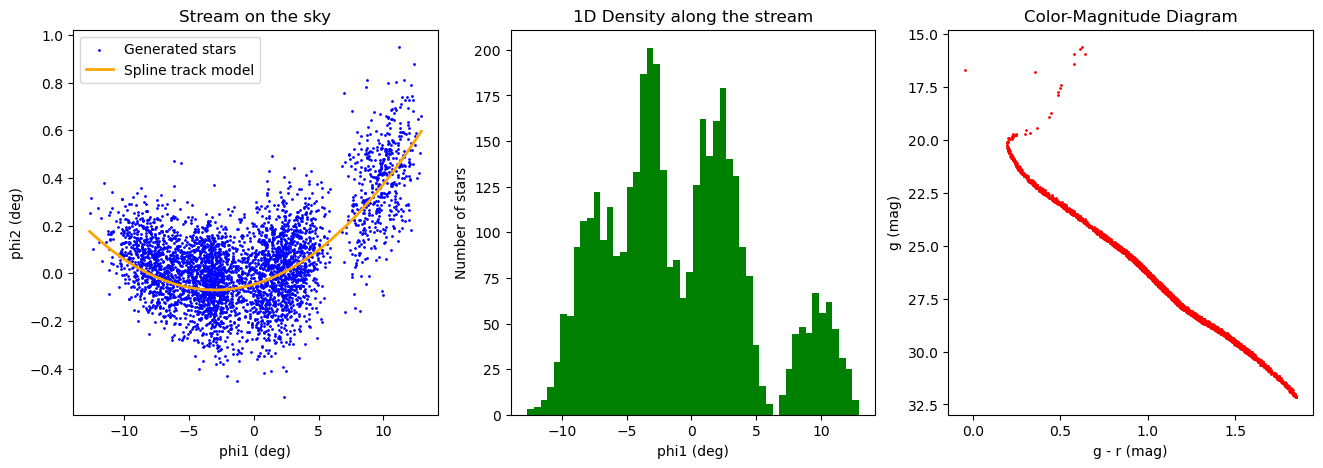

In [8]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# plotting the stream on the sky 
ax[0].scatter(stream_df_spline['phi1'], stream_df_spline['phi2'], s=1, color='blue', label = "Generated stars")
x_val  = np.sort(stream_df_spline['phi1'].values)
spline_val = scipy.interpolate.CubicSpline(center_nodes, center_node_values)(x_val)
ax[0].plot(x_val, spline_val, color='orange', lw=2, label='Spline track model')
ax[0].set_xlabel('phi1 (deg)')
ax[0].set_ylabel('phi2 (deg)')
ax[0].set_title('Stream on the sky')
ax[0].legend()

# Plotting the 1D density along the stream
ax[1].hist(stream_df_spline['phi1'], bins=50, color='green')
ax[1].set_xlabel('phi1 (deg)')
ax[1].set_ylabel('Number of stars')
ax[1].set_title('1D Density along the stream')

# plotting  Color magnitude diagram
ax[2].scatter(stream_df_spline['mag_g'] - stream_df_spline['mag_r'], stream_df_spline['mag_g'], s=1, color='red')
ax[2].set_xlabel('g - r (mag)')
ax[2].set_ylabel('g (mag)')
ax[2].invert_yaxis()
ax[2].set_title('Color-Magnitude Diagram')


# 3) Complete an existing catalog
`StreamModel.complete_catalog` fills only requested columns and preserves existing values (except mags/velocities, which are regenerated together for consistency).
- Dependencies: phi2 and dist need phi1; mags need dist+isochrone
- Input can be a DataFrame, dict, CSV path, or None+size

In [9]:
# Let's build a catalog with missing columns to complete
# Here for example we keep only 'phi1' and 'phi2', and drop others
stream_df_sub = stream_df.drop(columns=['mag_r', 'dist', 'mag_g', 'mu1', 'mu2', 'rv' ]).reset_index(drop=True)
print("\nCatalog with missing columns:")
print(stream_df_sub.head())


Catalog with missing columns:
       phi1      phi2
0  0.315409  0.188177
1 -6.697976  0.064819
2 -4.471355 -0.133839
3  6.859378  0.360799
4  4.757834  0.340916


## Fill every missing columns

In [ ]:
# Now we can use `complete_catalog` to fill in the missing columns amoung ['phi1', 'phi2', 'dist', 'mag_g', 'mag_r', 'mu1', 'mu2', 'rv']
completed_catalog = stream_model.complete_catalog(
    catalog=stream_df_sub,
    save_path=None,
    
    inplace=False,
    verbose=True
)
print(completed_catalog.head())

Velocity model not defined; skipping velocities.
Filled 5000 dist values.
Filled magnitudes for 5000 rows.
       phi1      phi2  dist      mag_g      mag_r
0  0.315409  0.188177  16.5  30.686021  29.049987
1 -6.697976  0.064819  16.5  29.342052  27.916179
2 -4.471355 -0.133839  16.5  28.263129  27.045057
3  6.859378  0.360799  16.5  21.161391  20.932156
4  4.757834  0.340916  16.5  28.564214  27.293647


## Fill only specific columns

In [11]:
# Example: fill only magnitudes
subset = stream_df_sub.copy()
completed_mags = stream_model.complete_catalog(
    catalog=subset,
    columns_to_add=["mag_g", "mag_r"],
    inplace=False,
    verbose=True,
)
completed_mags.head()

Filled 5000 dist values.
Filled magnitudes for 5000 rows.


,phi1,phi2,dist,mag_g,mag_r
0,0.315409,0.188177,16.5,32.219823,30.386254
1,-6.697976,0.064819,16.5,27.950772,26.777682
2,-4.471355,-0.133839,16.5,25.834753,24.926162
3,6.859378,0.360799,16.5,28.936618,27.592582
4,4.757834,0.340916,16.5,26.475269,25.483804


*Note: the distance modulus is also added, since it is needed to convert absolute magnitude sampled from the isochrone, to apparent magnitudes (`mag_g`and `mag_r` here).*

## Tips and troubleshooting

- If magnitudes are missing or NaN, ensure your config provides both `distance_modulus` and `isochrone` sections.
- To keep colors self-consistent, `complete_catalog` overwrites both `mag_g` and `mag_r` if it needs to generate either.
- Column names are standardized (e.g., 'g_mag' -> 'mag_g'); see `_standardize_columns_name`.
- Velocity model is currently a placeholder and returns NaN values.